# Advanced Lane Finding

Importing necessary libraries:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from collections import deque
from math import ceil

%matplotlib inline

## Camera Calibration and Distortion Correction

Methods to perform the camera calibration and distortion correction:

In [2]:
nx = 9
ny = 5
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)


def findChessboardCorners(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    return ret, corners


def drawChessboardCorners(ret, corners, img):
    # If chessboard corners found
    if ret == True:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


def getObjImgPointsAndShape(fname_pattern):
    objpoints = []
    imgpoints = []
    shape = None

    # Getting the image files
    images = glob.glob(fname_pattern)

    for fname in images:
        img = mpimg.imread(fname)

        if shape is None:
            shape = img.shape[1::-1]

        ret, corners = findChessboardCorners(img)

        # If found, adding image points and object points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    return objpoints, imgpoints, shape


class Calibration:
    def __init__(self, ret, mtx, dist, rvecs, tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs      


def calibrateCamera(fname_pattern):
    objpoints, imgpoints, shape = getObjImgPointsAndShape(fname_pattern);
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return Calibration(ret, mtx, dist, rvecs, tvecs)


def undistortImage(img, calibration):
    return cv2.undistort(img, calibration.mtx, calibration.dist, None, calibration.mtx)

Testing the identification of corners on a chessboard:

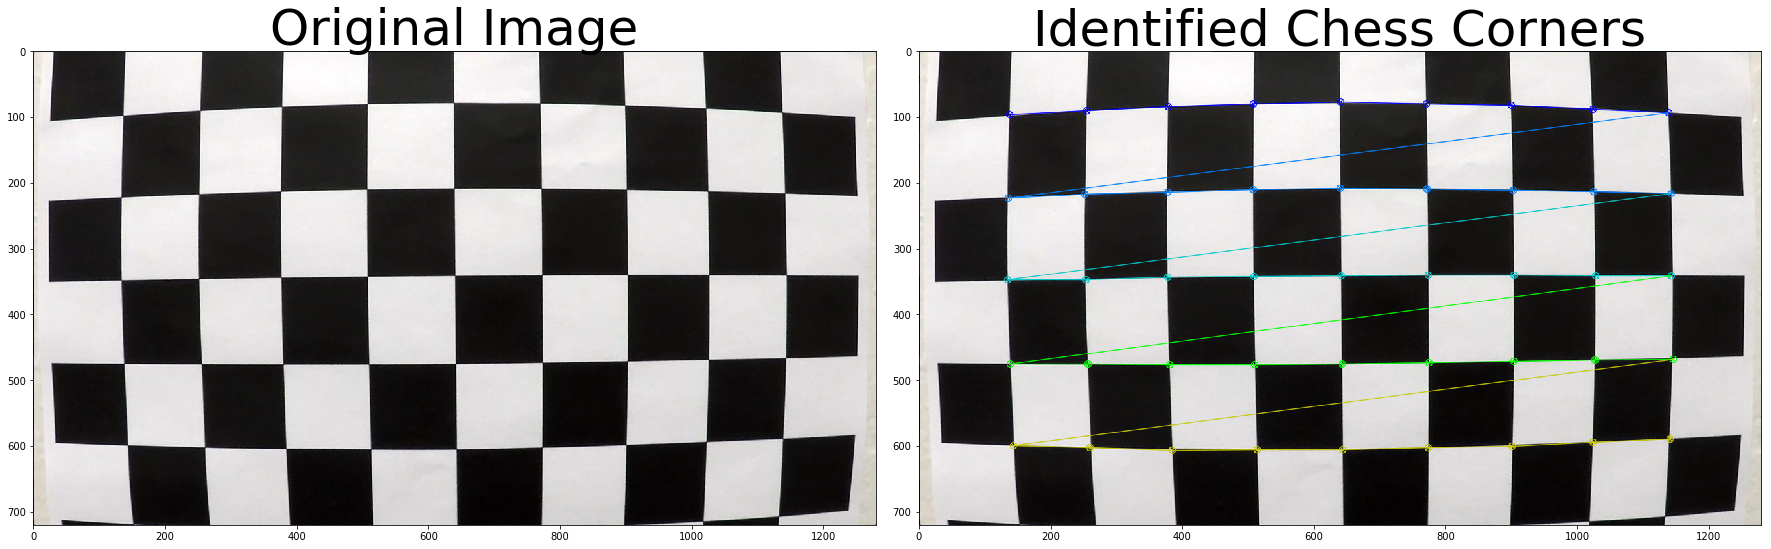

In [3]:
# Testing chess corners identification on a chassboard image
img = mpimg.imread('camera_cal/calibration1.jpg')
ret, corners = findChessboardCorners(img)
img_copy = img.copy()
drawChessboardCorners(ret, corners, img_copy)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_copy)
ax2.set_title('Identified Chess Corners', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/IdentifiedChessCorners.png")

### Calibrating the camera

In [4]:
# Calibrating camera
calibration = calibrateCamera('camera_cal/calibration*.jpg')

Testing the correction of distortion on a chessboard image:

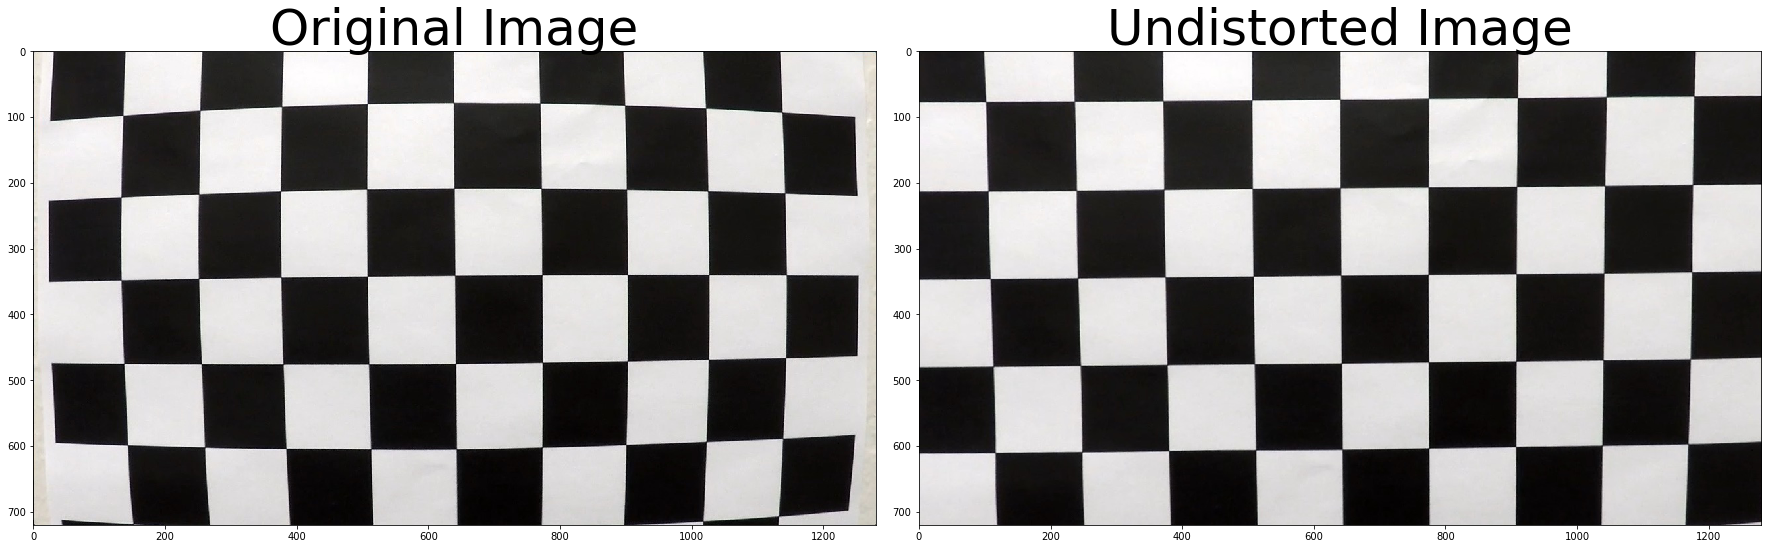

In [5]:
# Testing undistorting a chessboard image
img = mpimg.imread('camera_cal/calibration1.jpg')
undist = undistortImage(img, calibration)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/UndistortedChessBoard.png")

Testing the correction of distortion on a road image:

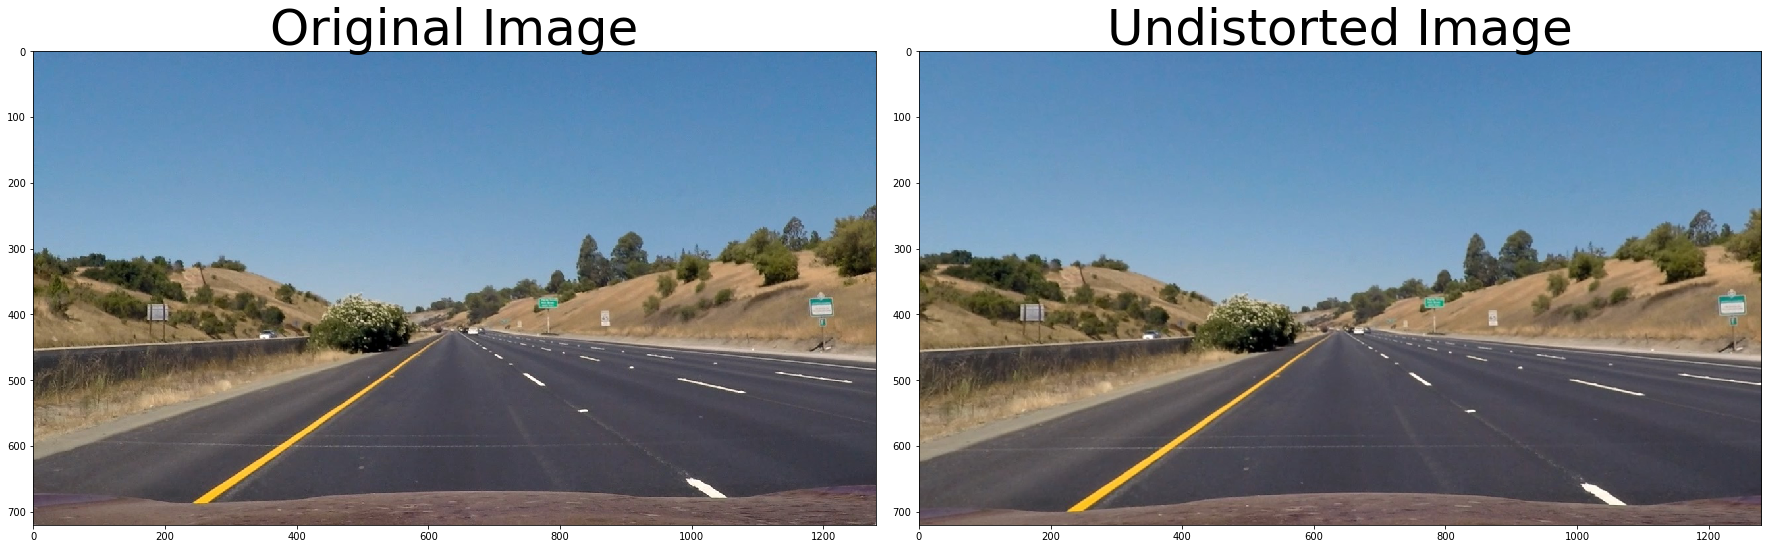

In [6]:
# Testing undistorting a road image
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistortImage(img, calibration)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/UndistortedRoadImage.png")

## Color/Gradient Threshold

Method to get a binary image based on color and gradient thresholds:

In [7]:
def getThresholdedBinaryImage(img, s_thresh=(170, 255), sx_thresh=(14, 50)):
    img = np.copy(img)

    # Convert to HLS color space and separate the L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    if sx_thresh is not None:
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    if s_thresh is not None: 
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combinning pixels passing any of both thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary * 255

Testing the application of color and gradient threshols to a road image:

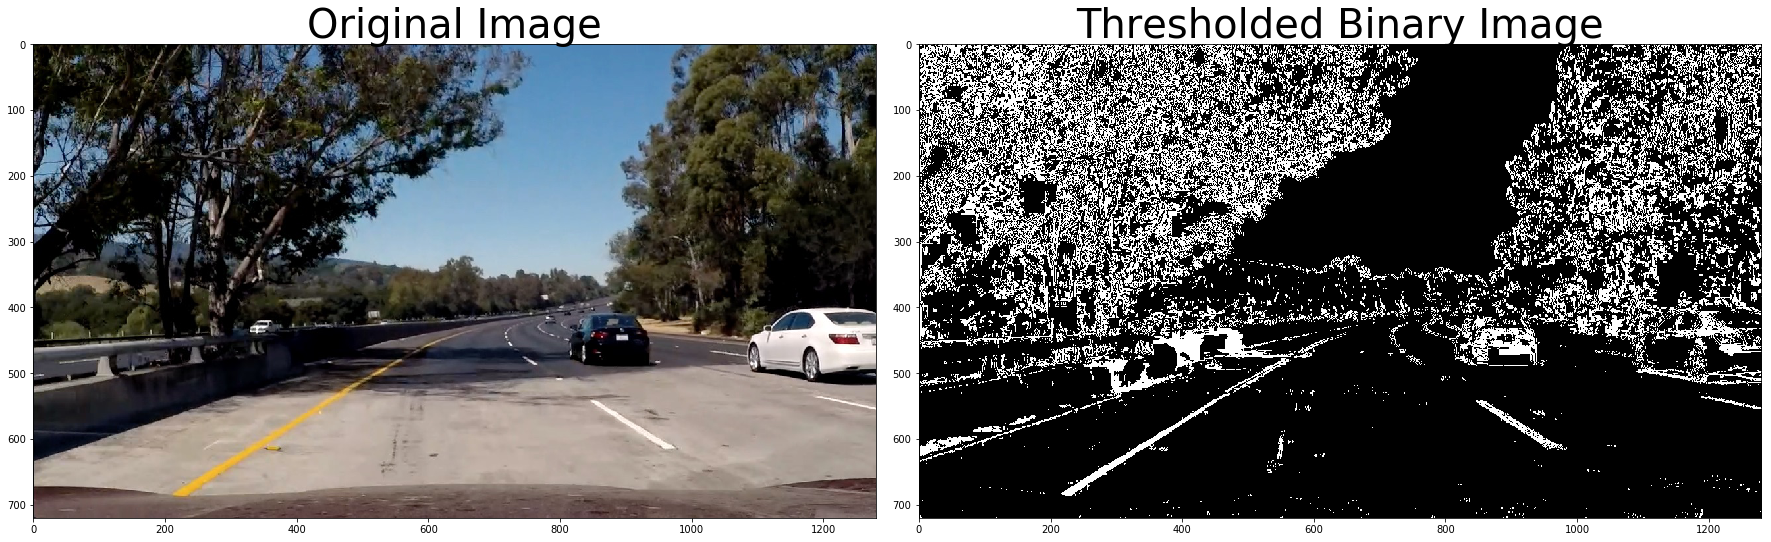

In [8]:
# Testing Color/Gradient threshold on a road image
img = mpimg.imread('test_images/test5.jpg')
binary = getThresholdedBinaryImage(img)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/ThresholdedBinaryImage.png")

## Perspective transform

Identifying some persective points that form a rectangle:

In [9]:
#(639, 420) # Vanishing point
src = np.float32([[520, 500], [765, 500], [200, 720], [1100, 720]])
dst = np.float32([[320, 500], [980, 500], [320, 720], [980, 720]])

Drawing the identified points in an undistorted image of a straight section of the road:

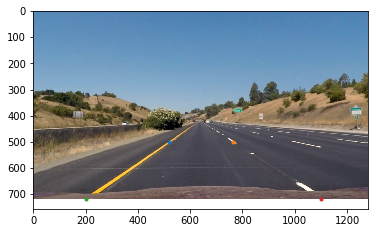

In [10]:
img = mpimg.imread('test_images/straight_lines1.jpg')
img = undistortImage(img, calibration)

plt.imshow(img)

for p in src:
    plt.plot(p[0], p[1], '.')

plt.savefig("output_images/PerspectivePoints.png")

Methods to calculate the perspective transform and warp/unwarp images:

In [11]:
class PerspectiveTransform:
    def __init__(self, perspectiveMatrix, inversePerspectiveMatrix):
        self.perspectiveMatrix = perspectiveMatrix
        self.inversePerspectiveMatrix = inversePerspectiveMatrix    


def getPerspectiveTransform(src, dst):
    # Computing the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Computing the inverse perspective transform
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Retuning perspective transform object
    return PerspectiveTransform(M, M_inv)


def getWarpedImage(img, perspectiveTransform):
    return cv2.warpPerspective(img, perspectiveTransform.perspectiveMatrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


def getUnwarpedImage(img, perspectiveTransform):
    return cv2.warpPerspective(img, perspectiveTransform.inversePerspectiveMatrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

### Calculating the perspective transform

In [12]:
perspectiveTransform = getPerspectiveTransform(src, dst)

Testing perspective transform on a road image:

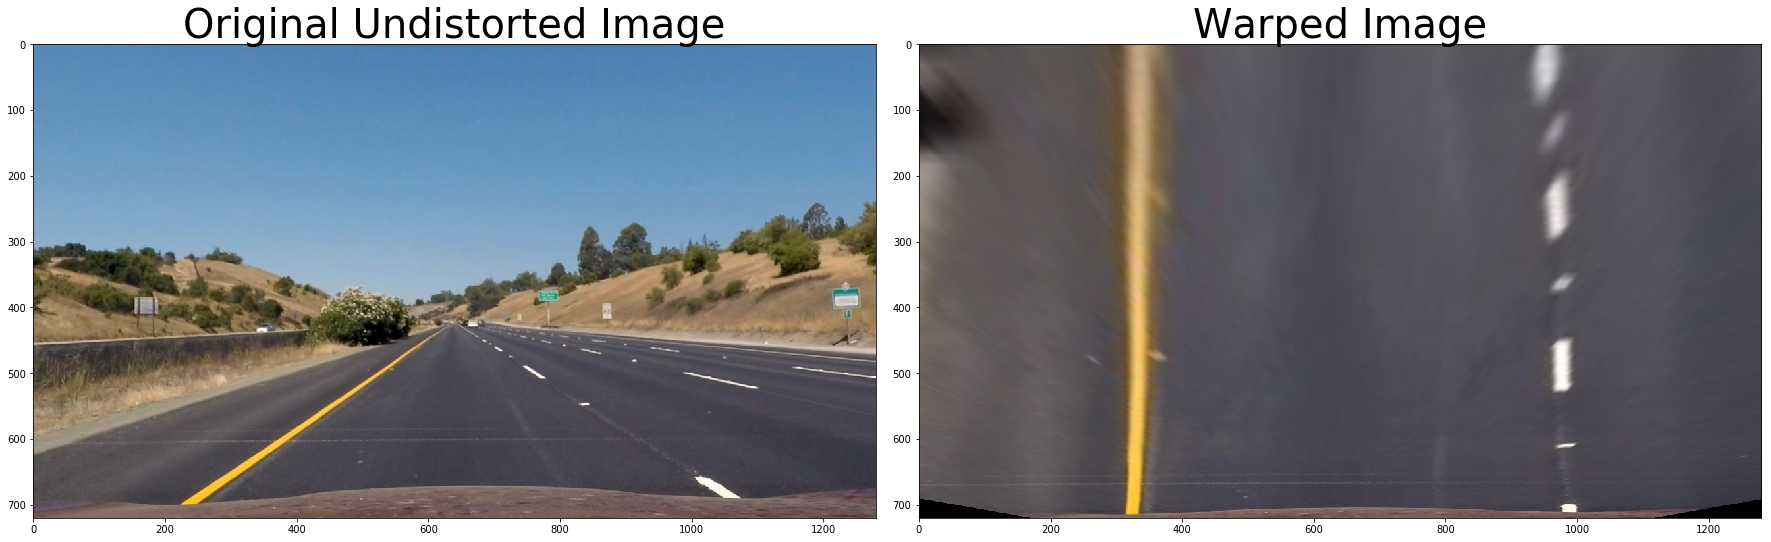

In [13]:
# Testing perspective transform on a road image
img = mpimg.imread('test_images/straight_lines1.jpg')
img = undistortImage(img, calibration)
warped = getWarpedImage(img, perspectiveTransform)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Undistorted Image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/WarpedImage.png")

Testing inverse perspective transform on a road image:

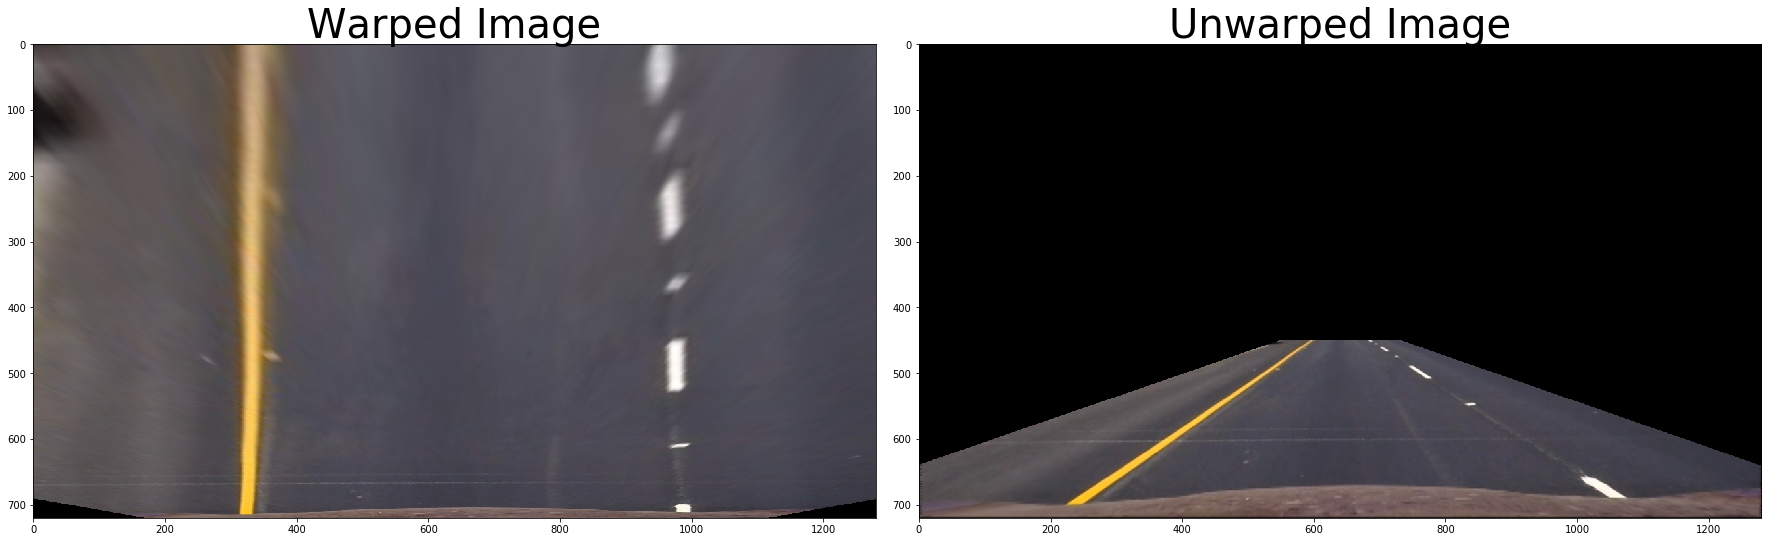

In [14]:
# Testing inverse perspective transform
unwarped = getUnwarpedImage(warped, perspectiveTransform)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=40)
ax2.imshow(unwarped)
ax2.set_title('Unwarped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/UnwarpedImage.png")

Testing the process to get an image to be used to identify lane lines and calculate curvatures:

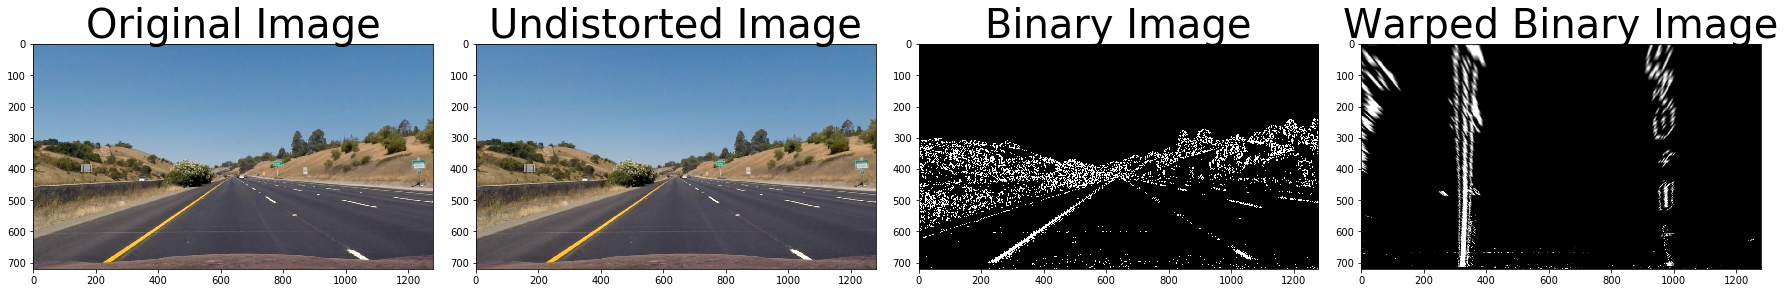

In [15]:
# Testing mechanism to get image to identify lane lines and calculate curvatures
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistortImage(img, calibration)
binary = getThresholdedBinaryImage(undist)
warped_binary = getWarpedImage(binary, perspectiveTransform)

# Plotting the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
ax3.imshow(binary, cmap='gray')
ax3.set_title('Binary Image', fontsize=40)
ax4.imshow(warped_binary, cmap='gray')
ax4.set_title('Warped Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/BirdsEyeProcess.png")

Grouping color/gradient threshold and perspective transform in one function:

In [16]:
def getBirdsEyeView(undist):
    binary = getThresholdedBinaryImage(undist)
    warped_binary = getWarpedImage(binary, perspectiveTransform)
    return warped_binary

Testing birds-eye view function:

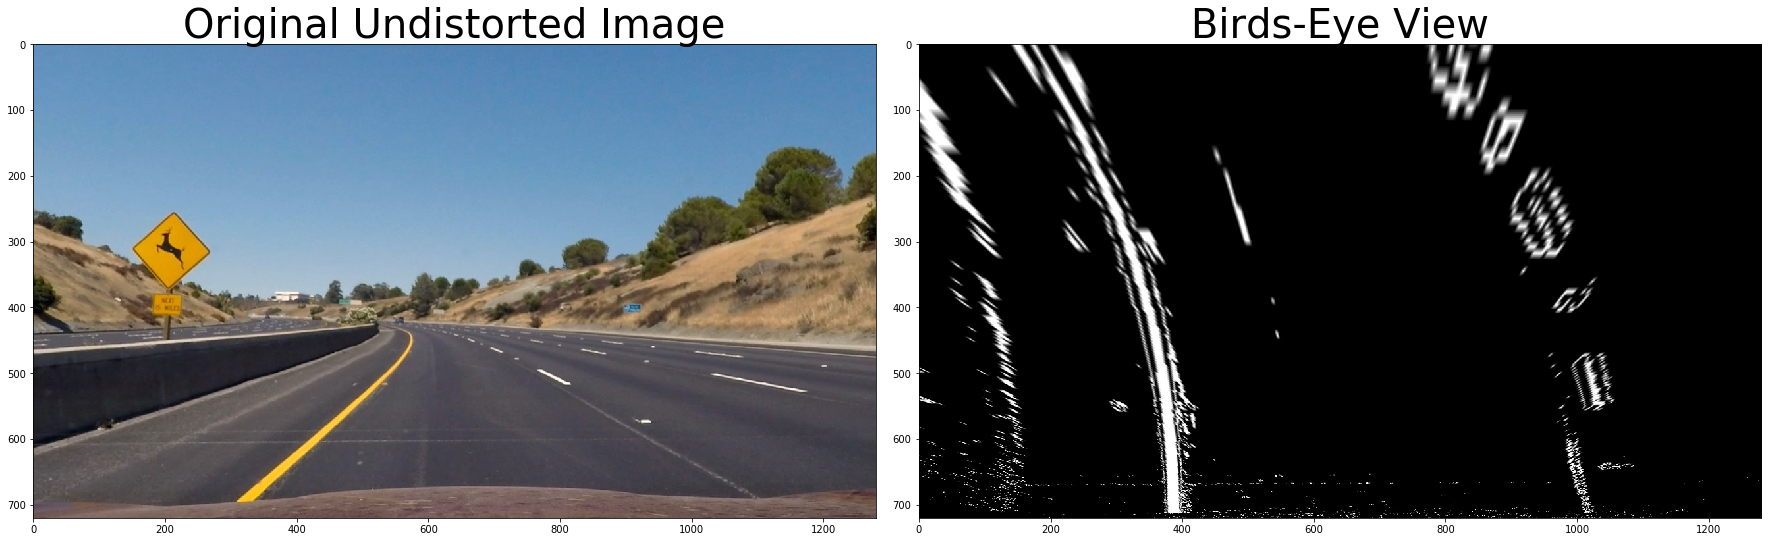

In [17]:
# Testing birds-eye view function
img = mpimg.imread('test_images/test2.jpg')
undist = undistortImage(img, calibration)
birds_eye_view_img = getBirdsEyeView(undist)

# Plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Undistorted Image', fontsize=40)
ax2.imshow(birds_eye_view_img, cmap='gray')
ax2.set_title('Birds-Eye View', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/WarpedBinaryImage.png")

## Lane Lines Detection

Methods to perform the lane lines detection via convolution, and fitting the second degree polynomials representing the left and right lines:

In [18]:
# window settings
window_width  = 80
window_height = 80  # Breaking image into 9 vertical layers since image height is 720
margin        = window_width/2 # How much to slide left and right for searching


def applyLaneLinePolynomial(y, fit):
    return fit[0] * y**2 + fit[1] * y + fit[2]


def findWindowCentroids(img, l_fit=None, r_fit=None):
    # To store the (left,right) window centroid positions per level
    window_centroids = []
    # Creating our window template that we will use for convolutions
    window = np.ones(window_width)

    max_x = img.shape[1]
    max_y = img.shape[0]

    # If not given polynomial, finding the two starting positions for the left and right lane lines
    # By using np.sum getting the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    # Summing quarter bottom of image to get slice, could use a different ratio
    # If polynomial is given starting from the calculated init point on the bottom

    if l_fit is None:
        l_sum    = np.sum(img[int(3 * max_y/4):, :int(max_x/2)], axis=0)
        l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
    else:
        l_center = applyLaneLinePolynomial(max_y, l_fit)

    if r_fit is None:
        r_sum    = np.sum(img[int(3 * max_y/4):, int(max_x/2):], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(max_x/2)
    else:
        r_center = applyLaneLinePolynomial(max_y, r_fit)

    # Adding the found centroids for the first layer
    window_centroids.append((l_center, r_center))

    # Going through each layer looking for max pixel locations
    for level in range(1, (int)(max_y / window_height)):
        # Convolving the window into the vertical slice of the image
        img_layer = np.sum(img[int(max_y - (level+1) * window_height):
                               int(max_y - level * window_height), :],
                           axis=0)
        conv_signal = np.convolve(window, img_layer)
        # Finding the best left centroid by using past left center as a reference
        # Using window_width/2 as offset because convolution signal reference is at right side of window,
        # not center of window
        offset = window_width/2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, max_x))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        # Finding the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Adding what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids


def windowMask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level+1) * height) : int(img_ref.shape[0] - level * height),
           max(0, int(center - width/2)) : min(int(center + width/2), img_ref.shape[1])] = 1
    return output


def identifyPointsOfLaneLinesInImage(window_centroids, img):
    l_points_img = np.zeros_like(img)
    r_points_img = np.zeros_like(img)

    # If any window centers where found
    if len(window_centroids) > 0:

        # Going through each level and draw the windows
        for level in range(0, len(window_centroids)):
            # windowMask is a function to draw window areas
            l_mask = windowMask(window_width, window_height, img, window_centroids[level][0], level)
            r_mask = windowMask(window_width, window_height, img, window_centroids[level][1], level)
            # Adding graphic points from window mask here to total pixels found 
            l_points_img[(img >= 128) & (l_mask == 1)] = 255
            r_points_img[(img >= 128) & (r_mask == 1)] = 255

    return l_points_img, r_points_img


def getPointsOfLaneLine(points_img):
    return points_img.nonzero()


def getPointsOfLaneLines(l_points_img, r_points_img):
    return getPointsOfLaneLine(l_points_img), getPointsOfLaneLine(r_points_img)


def fitLaneLinePolynomial(points):
    return np.polyfit(points[0], points[1], 2)


def fitLaneLinesPolynomials(l_points, r_points):
    left_fit  = np.polyfit(l_points[0], l_points[1], 2)
    right_fit = np.polyfit(r_points[0], r_points[1], 2)
    return left_fit, right_fit

Methods to help with the visualization of the results of the process to identify lane lines:

In [19]:
def drawWindowCentroids(window_centroids, img):
    # If any window centers where found
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Going through each level and draw the windows
        for level in range(0, len(window_centroids)):
            # windowMask is a function to draw window areas
            l_mask = windowMask(window_width, window_height, img, window_centroids[level][0], level)
            r_mask = windowMask(window_width, window_height, img, window_centroids[level][1], level)
            # Adding graphic points from window mask here to total pixels found 
            l_points[l_mask == 1] = 255
            r_points[r_mask == 1] = 255

        # Drawing the results
        # adding both left and right window pixels together
        template = np.array(r_points + l_points, np.uint8)
        # creating a zero color channel
        zero_channel = np.zeros_like(template)
        # making window pixels cyan
        template = np.array(cv2.merge((zero_channel, template, template)), np.uint8)
        # making the original road pixels 3 color channels
        warpage= np.dstack((img, img, img))
        # overlaying the orignal road image with window results
        return cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

    # If no window centers found, just displaying orginal road image
    else:
        return np.array(cv2.merge((img, img, img)),np.uint8)


def drawIdentifiedPointsOfLaneLines(l_points_img, r_points_img, img):
    output = img.copy()
    # Drawing left lane line's points in red
    output[l_points_img > 0] = [255, 0, 0]
    # Drawing right lane line's points in blue
    output[r_points_img > 0] = [0, 0, 255]
    return output


def drawLaneLinesPolynomials(l_fit, r_fit, ref_img, plot, l_color = 'yellow', r_color = 'yellow', linewidth=1.0): 
    y = np.linspace(0, ref_img.shape[0] - 1, ref_img.shape[0])
    l_x = applyLaneLinePolynomial(y, l_fit)
    r_x = applyLaneLinePolynomial(y, r_fit)
    # Drawing the predicted lane points from polynomials in yellow
    plot.plot(l_x, y, color=l_color, linewidth=linewidth)
    plot.plot(r_x, y, color=r_color, linewidth=linewidth)

Testing the phases on the process to identify line lanes:

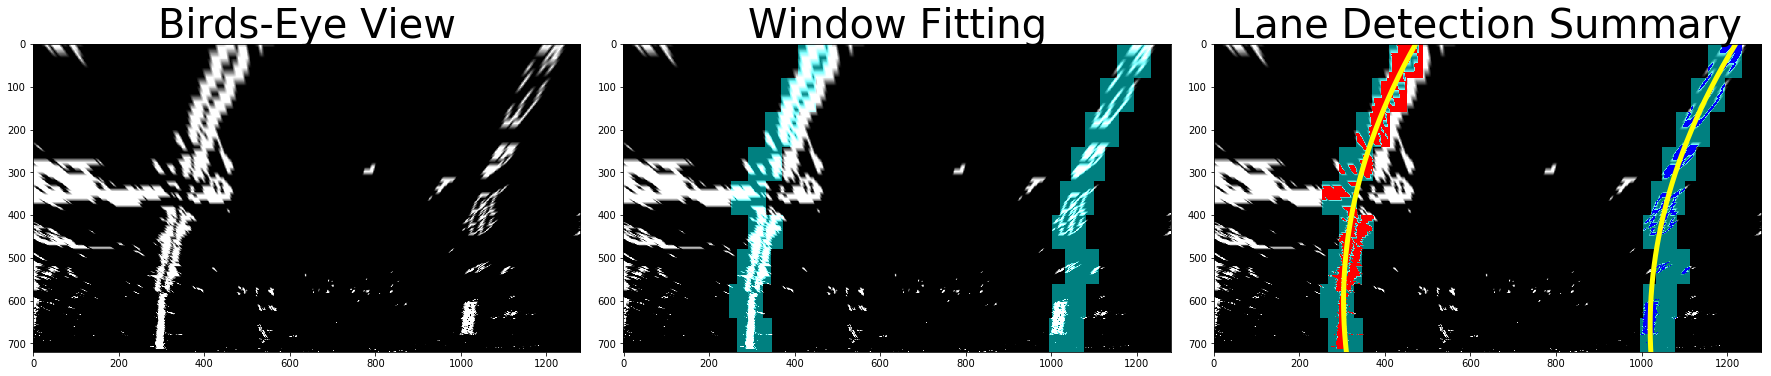

In [20]:
# Testing lane detection's phases

img = mpimg.imread('test_images/test5.jpg')
undist = undistortImage(img, calibration)
birds_eye_img = getBirdsEyeView(undist)

# Getting the searching windows' centroids
window_centroids = findWindowCentroids(birds_eye_img)
# Getting the identified points for left and right lane liness
l_points_img, r_points_img = identifyPointsOfLaneLinesInImage(window_centroids, birds_eye_img)
# Getting the (x,y) list of points for the left and right lane lines
l_points, r_points = getPointsOfLaneLines(l_points_img, r_points_img)
# Getting the fitted polynomials for the lane lines
l_fit, r_fit = fitLaneLinesPolynomials(l_points, r_points)


# Plotting the result
windows = drawWindowCentroids(window_centroids, birds_eye_img)
results_summary = drawIdentifiedPointsOfLaneLines(l_points_img, r_points_img, windows)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(birds_eye_img, cmap='gray')
ax1.set_title('Birds-Eye View', fontsize=40)
ax2.imshow(windows)
ax2.set_title('Window Fitting', fontsize=40)
ax3.imshow(results_summary)
drawLaneLinesPolynomials(l_fit, r_fit, results_summary, ax3, linewidth=5.0)
ax3.set_title('Lane Detection Summary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/LaneDetectionProcess.png")

Testing the line lane detection process, via plotting the fitted second degree polynomials:

## Lane Curvature Determination

Methods to calculate the radious of the lane lines' curvature, and distance from the camera's center to the lane lines:

In [21]:
# Defining conversions in x and y from pixels space to meters
# Meters per pixel in y dimension
LANE_WIDTH_METERS = 3.7
ym_per_pix = 600/720
xm_per_pix = LANE_WIDTH_METERS/660


def calculateCurvatureOfLaneLine(fit, ref_img):
    max_y = ref_img.shape[0]
    return ((1 + (2 * fit[0] * max_y * ym_per_pix + fit[1])**2)**1.5) / np.absolute(2 * fit[0])


def calculateCurvatureOfLaneLines(l_fit, r_fit, ref_img):
    left_curve_rad = calculateCurvatureOfLaneLine(l_fit, ref_img)
    right_curve_rad = calculateCurvatureOfLaneLine(r_fit, ref_img)
    return left_curve_rad, right_curve_rad


def calculateLaneLineBasePosition(fit, ref_img):
    max_y = ref_img.shape[0]
    mid_x = ref_img.shape[1] / 2
    return (applyLaneLinePolynomial(max_y, fit) - mid_x) * xm_per_pix


def calculateLaneLinesBasePositions(l_fit, r_fit, ref_img):
    return calculateLaneLineBasePosition(l_fit, ref_img), calculateLaneLineBasePosition(r_fit, ref_img)


def calculateDistanceToLaneLines(l_fit, r_fit, ref_img):
    return -calculateLaneLineBasePosition(l_fit, ref_img), calculateLaneLineBasePosition(r_fit, ref_img)

Testing curvature determination and distance to lane lines:

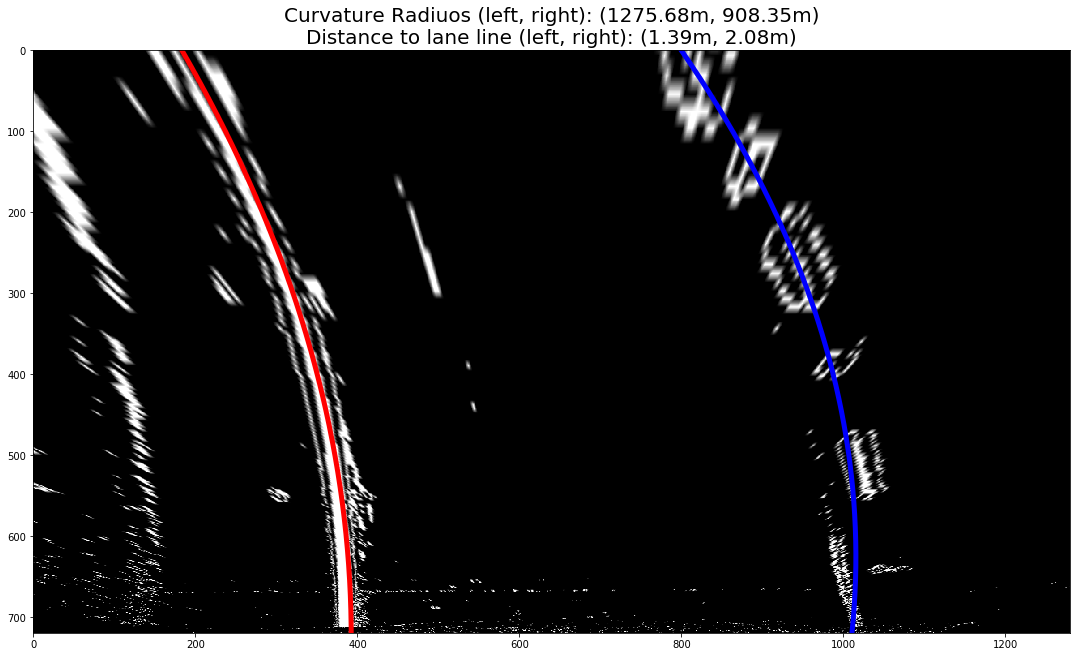

In [22]:
# Testing curvature determination

img = mpimg.imread('test_images/test2.jpg')
undist = undistortImage(img, calibration)
birds_eye_img = getBirdsEyeView(undist)

# Getting the lane lines' polynomials
window_centroids = findWindowCentroids(birds_eye_img)
l_points_img, r_points_img = identifyPointsOfLaneLinesInImage(window_centroids, birds_eye_img)
l_points, r_points = getPointsOfLaneLines(l_points_img, r_points_img)
l_fit, r_fit = fitLaneLinesPolynomials(l_points, r_points)

l_curve_rad, r_curve_rad = calculateCurvatureOfLaneLines(l_fit, r_fit, birds_eye_img)
l_dist, r_dist = calculateDistanceToLaneLines(l_fit, r_fit, birds_eye_img)


# Plotting the result
warpage= np.dstack((birds_eye_img, birds_eye_img, birds_eye_img))
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warpage)
drawLaneLinesPolynomials(l_fit, r_fit, warpage, ax1, l_color = 'red', r_color = 'blue', linewidth = 5.0)
ax1.set_title(('Curvature Radiuos (left, right): ({:01.2f}m, {:01.2f}m)\n' +
               'Distance to lane line (left, right): ({:01.2f}m, {:01.2f}m)')
              .format(l_curve_rad, r_curve_rad, l_dist, r_dist),
              fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/LaneCurvatureDetermination.png")

### Grouping in method to detect lane lines

Method to draw the detected lane in an udistorted image:

In [23]:
# Defining a class to receive the characteristics of each line detection
class Line():
    def __init__(self, fit, allx, ally, image):
        self.current_fit = fit
        self.allx = allx
        self.ally = ally
        self.image = image
        self.radius_of_curvature = calculateCurvatureOfLaneLine(fit, image)
        self.base_position = calculateLaneLineBasePosition(fit, image)


BUFFER_SIZE = 50

# A subclass of line to mantain the previosly identified lines and
# use them to implemet fault tolerance mechanisms
class BufferedLine(Line):
    def __init__(self, detected, line, prev_buffered_line=None):
        Line.__init__(self, line.current_fit, line.allx, line.ally, line.image)

        # If the line was successfully detected, i.e. passed the sanity test
        self.detected = detected

        # Getting the previously detected lines
        if prev_buffered_line is None:
            self.recent_fits = deque()
        else:
            self.recent_fits = prev_buffered_line.recent_fits

        # Getting last line out of the buffer
        if line is not None and detected:
            # If the current line was successfully detected is added to the buffer
            self.recent_fits.append(line.current_fit)
            while len(self.recent_fits) > BUFFER_SIZE:
                self.recent_fits.popleft()
        else:
            if len(self.recent_fits) > 0:
                self.recent_fits.popleft()

        # Calculating the best fit, to do a prediction in case the line was not successfully detected
        # and smothing the results
        if len(self.recent_fits) > 0:
            fits = np.array(self.recent_fits)
            if (self.detected):
                # Using a rate to give the most recently detected line more weight in the result
                self.avg_fit = (0.25 * line.current_fit + 
                                0.75 * np.array([np.mean(fits[:,0]), np.mean(fits[:,1]), np.mean(fits[:,2])]))
            else:
                self.avg_fit = [np.mean(fits[:,0]), np.mean(fits[:,1]), np.mean(fits[:,2])]
        else:
            self.avg_fit = line.current_fit

    def avg_radius_of_curvature(self):
        return calculateCurvatureOfLaneLine(self.avg_fit, self.image)

    def avg_base_position(self):
        return calculateLaneLineBasePosition(self.avg_fit, self.image)


def getDistanceBetweenLaneLinesInMeters(l_line, r_line, ref_img):
    max_y = ref_img.shape[0]
    l_x = applyLaneLinePolynomial(max_y, l_line.current_fit)
    r_x = applyLaneLinePolynomial(max_y, r_line.current_fit)
    return np.abs(l_x - r_x) * xm_per_pix


def verifyParallelism(l_line, r_line, a_diff_threshold=0.01, b_diff_threshold=0.35):
    if np.abs(l_line.current_fit[0] - r_line.current_fit[0]) > a_diff_threshold:
        return False
    if np.abs(l_line.current_fit[1] - r_line.current_fit[1]) > b_diff_threshold:
        return False
    return True


def verifyContinuityOfLaneLine(line, prev_line,
                               a_diff_threshold=0.01, b_diff_threshold=0.35, c_diff_threshold=200):
    if np.abs(line.current_fit[2] - prev_line.avg_fit[2]) > c_diff_threshold:
        return False
    if np.abs(line.current_fit[1] - prev_line.avg_fit[1]) > b_diff_threshold:
        return False
    if np.abs(line.current_fit[0] - prev_line.avg_fit[0]) > a_diff_threshold:
        return False
    return True


def sanityCheck(l_line, r_line, prev_l_line, prev_r_line, ref_image):
    if l_line is None or r_line is None:
        return False
    if not verifyParallelism(l_line, r_line):
        return False
    if np.abs(getDistanceBetweenLaneLinesInMeters(l_line, r_line, ref_image) - LANE_WIDTH_METERS) > 0.4:
        return False
    if prev_l_line is not None and not verifyContinuityOfLaneLine(l_line, prev_l_line):
        return False
    if prev_r_line is not None and not verifyContinuityOfLaneLine(r_line, prev_r_line):
        return False
    return True


def detectLaneLines(image, prev_l_line=None, prev_r_line=None,
                    window_width = window_width, window_height = window_height, margin = margin):

    # Getting the searching windows' centroids
    window_centroids = findWindowCentroids(image,
                                           l_fit=(prev_l_line.avg_fit if prev_l_line is not None else None),
                                           r_fit=(prev_r_line.avg_fit if prev_r_line is not None else None))
    # Getting the identified points for left and right lanes
    l_points_img, r_points_img = identifyPointsOfLaneLinesInImage(window_centroids, image)
    # Getting the collection of points for the left and right lane lines
    l_points, r_points = getPointsOfLaneLines(l_points_img, r_points_img)
    # Getting the polynomials for the left and right lane lines
    l_fit, r_fit = fitLaneLinesPolynomials(l_points, r_points)

    # Creating the left and right lane lines
    l_line = Line(l_fit, l_points[1], l_points[0], image)
    r_line = Line(r_fit, r_points[1], r_points[0], image)

    # Performing sanity check to the identified lines
    detected = sanityCheck(l_line, r_line, prev_l_line, prev_r_line, image)

    l_line = BufferedLine(detected, l_line, prev_l_line)
    r_line = BufferedLine(detected, r_line, prev_r_line)

    return l_line, r_line

Drawing detected lanes in road image

In [24]:
def drawFoundLaneOverImage(undist, l_line, r_line):
    # Creating some sample points fro polynomials to draw the lanes
    y = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    l_x = applyLaneLinePolynomial(y, l_line.avg_fit) if l_line is not None else None
    r_x = applyLaneLinePolynomial(y, r_line.avg_fit) if r_line is not None else None

    # Getting radius of curvature and distance to center
    curv_rad = None
    dist_to_center = None
    if l_line is not None and r_line is not None:
        curv_rad = (l_line.avg_radius_of_curvature() + r_line.avg_radius_of_curvature()) / 2.0
        dist_to_center = (r_line.avg_base_position() + l_line.avg_base_position()) / 2.0
    elif l_line is not None:
        curv_rad = l_line.avg_radius_of_curvature()
    elif r_line is not None:
        curv_rad = r_line.avg_radius_of_curvature()

    # Create an images to draw the lane and lines on
    warp_zero = np.zeros((undist.shape[0], undist.shape[1])).astype(np.uint8)
    lane_img = np.dstack((warp_zero, warp_zero, warp_zero))
    l_line_img = np.dstack((warp_zero, warp_zero, warp_zero))
    r_line_img = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_x, y]))]) if l_x is not None else None
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x, y])))]) if r_x is not None else None
    pts = np.hstack((pts_left, pts_right)) if pts_left is not None and pts_right is not None else None

    # Draw the lane onto the warped blank image
    if pts is not None:
        cv2.fillPoly(lane_img, np.int_([pts]), (0, 255, 0))
    if l_line is not None:
        l_line_img[l_line.ally, l_line.allx] = [255, 0, 0]
    if r_line is not None:
        r_line_img[r_line.ally, r_line.allx] = [0, 0, 255]

    # Warpping the blank back to original image space using inverse perspective matrix
    lane_img = getUnwarpedImage(lane_img, perspectiveTransform)
    l_line_img = getUnwarpedImage(l_line_img, perspectiveTransform)
    r_line_img = getUnwarpedImage(r_line_img, perspectiveTransform)
    l_points = l_line_img.nonzero()
    r_points = r_line_img.nonzero()
    # Combinning the result with the original image
    result = cv2.addWeighted(undist, 1, lane_img, 0.2, 0)
    result[l_points[0], l_points[1]] = np.array([255, 0, 0]) * 0.6 + result[l_points[0], l_points[1]] * 0.4
    result[r_points[0], r_points[1]] = np.array([0, 0, 255]) * 0.6 + result[r_points[0], r_points[1]] * 0.4

    if curv_rad is not None:
        cv2.putText(result, 'Radius of Curvature = {}'
                    .format('{:01.2f}m'.format(curv_rad) if curv_rad < 5000 else 'straight'),
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    if dist_to_center is not None:
        cv2.putText(result,
                    'Vehicle is {:01.2f}m {} of center'
                    .format(np.abs(dist_to_center), 'left' if dist_to_center > 0.0 else 'right'),
                    (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    # Displaying bar informing how fill the buffer is
    #cv2.putText(result, 'Detection Buffer: {0:03}%'
    #            .format(int(ceil(100 * ((len(l_line.recent_fits) + len(r_line.recent_fits)) / 2) / BUFFER_SIZE))),
    #            (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    buffer_disp_len = 10
    buffer_len = len(l_line.recent_fits)
    cv2.putText(result, 'Detection Buffer: |{}|'.format(''.join(
                ['*' if buffer_len >= BUFFER_SIZE or buffer_len > i * BUFFER_SIZE / buffer_disp_len else ' '
                 for i in range(buffer_disp_len + 1)])),
                (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    return result

Testing lane detection:

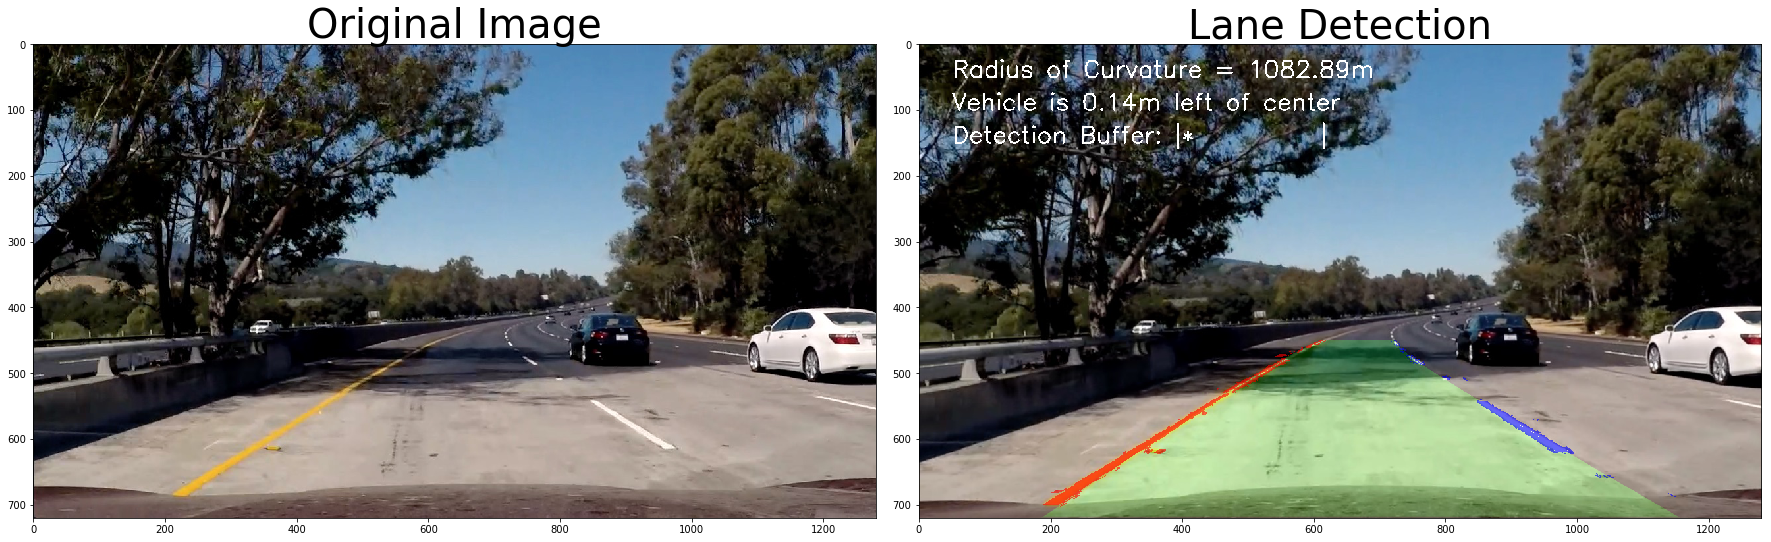

In [25]:
img = mpimg.imread('test_images/test5.jpg')

undist = undistortImage(img, calibration)
birds_eye_img = getBirdsEyeView(undist)
l_line, r_line = detectLaneLines(birds_eye_img)
result = drawFoundLaneOverImage(undist, l_line, r_line)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Lane Detection', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/LaneDetectionSample.png")

In [26]:
buff_l_line = None
buff_r_line = None


def process_image(image):
    global buff_l_line
    global buff_r_line

    undist = undistortImage(image, calibration)
    birds_eye_img = getBirdsEyeView(undist)
    buff_l_line, buff_r_line = detectLaneLines(birds_eye_img, prev_l_line=buff_l_line, prev_r_line=buff_r_line)

    return drawFoundLaneOverImage(undist, buff_l_line, buff_r_line)

## Video

In [27]:
buff_l_line = None
buff_r_line = None

video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [04:48<00:00,  4.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 4min 58s, sys: 35.4 s, total: 5min 33s
Wall time: 4min 50s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))